# 2) Policy optimization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gridworld import GridWorld1
import gridrender as gui
import warnings
warnings.filterwarnings("ignore")

In [2]:
env = GridWorld1

### Model description

__Choice of stepsize :__

In order to respect the Robbins-Monro conditions, we set $\alpha_{N}=(s,a)\longmapsto\frac{1}{1+N(s,a)}$ and we hence verify :

$$\forall s, a\in\mathcal{X}\times\mathcal{A},\, \sum_{n\geq0}\alpha_{N(s,a)} = \infty\enspace\sum_{n\geq0}\alpha_{N(s,a)}^{2} < \infty
$$

__Choice of $T_{max}$:__

As reward is here bounded by $R_{max}=1$, we can use the notion of effective horizon and set 

$$
T_{max} = \frac{-\log\left(\frac{\delta}{R_{max}}\right)}{1-\gamma}
$$

to be $\delta$ close to the infinite horizon

__Choice of $\varepsilon$:__

_See below_

__Exploration policy :__

The chosen exploration policy picks the action maximizing the $Q$-value with probability $(1-\varepsilon)$, otherwise randomly draws an action out of the available actions with uniform probability distribution.

__Algorithm :__

Until $t\geq T_{max}$ or terminal state is reached :

- Take action $a_{t}$ from $s_{i_t}$ and observe $(s_{i_{t+1}}, r_{t})$

- Take $a_{t+1} = \underset{b\in\mathcal{A}(s_{i_{t+1}})}{\text{Argmax}}\hat{Q}(s_{i_{t+1}}, b)$ with probabilty $1-\varepsilon$ or randomly draw an action from $\mathcal{A}(s_{i_{t+1}})$ with probability $\varepsilon$

- Update $\hat{Q}(s_{i_t}, a_t) \leftarrow (1-\alpha_{N(s_{i_t}, a_t)})\hat{Q}(s_{i_t}, a_t) + \alpha_{N(s_{i_t}, a_t)}\left[r_{t} + \gamma\underset{b\in\mathcal{A}(s_{i_{t+1}})}{\max}\hat{Q}(s_{i_{t+1}}, b)\right]$ 

In [3]:
def stepsize(n):
    try :
        return 1 / float(1 + n)
    except ZeroDivisionError:
        raise ZeroDivisionError("Stepsize computation requires at least 1 visit")

def initialize(n_states, n_actions):
    Q = np.zeros((n_states, n_actions))
    nr_visit = np.zeros((n_states, n_actions))
    return Q, nr_visit

def exploration_policy(env, state, Q, eps):

    # Get available actions
    available_actions = env.state_actions[state]
    # Compute corresponding indexes in Q matrix
    nr_available_actions = len(available_actions)
    valid_indexes = [np.repeat(state, nr_available_actions), available_actions]
    # Draw next action
    rdm_draw = np.random.rand()
    if rdm_draw > eps:
        action_idx = np.argmax(Q[valid_indexes])
        action = available_actions[action_idx]
    else:
        action = np.random.choice(valid_indexes[1])
    return action
    
def iterate(env, state, action, Q, nr_visit, stepsize, eps):

    # Take step
    next_state, reward, absorb = env.step(state, action)

    # Define next action
    next_action = exploration_policy(env, next_state, Q, eps)

    # Update Q-value
    rm_coeff = stepsize(nr_visit[state, action])
    Q[state, action] = (1 - rm_coeff) * Q[state, action] + rm_coeff * (reward + env.gamma * np.max(Q[next_state]))

    # Add visit of next state
    nr_visit[next_state, next_action] += 1
    
    return next_state, reward, absorb, next_action, Q, nr_visit

def get_greedy_policy(Q):
    policy = np.argmax(Q, axis=1)
    return policy

def compute_state_value(Q, policy):
    n_states = len(Q)
    indexes = [range(n_states), [policy[i] for i in range(n_states)]]
    V = Q[indexes]
    return V

### Execution

In [4]:
DELTA = 0.05  # 0.05 close to infinite horizon
RMAX = 1      # reward bounded by 1
V_STAR = [.877, .928, .988, .0, .824, .928, .0, .778, .824, .877, .828]

In [6]:
def run_Q_learning(env, nr_episodes, eps, Rmax=RMAX, delta=DELTA, opt_value=V_STAR):
    Tmax = - np.log(delta / Rmax) / (1 - env.gamma)
    
    n_states = env.n_states
    n_actions = len(env.action_names)
    
    Q, nr_visit = initialize(n_states, n_actions)
    cum_rewards = []
    distance_opt_value = []
    
    for episode in range(nr_episodes):
        # take random initial state
        initial_state = env.reset()
        
        # initialize loop variables
        state = initial_state
        action = exploration_policy(env, state, Q, eps)
        nr_visit[state, action] += 1
        t = 0
        absorb = False
        
        # intialize cumulative reward record
        episode_reward = 0
        
        while not absorb and t < Tmax:
            # iterate and increment reward
            t += 1
            state, reward, absorb, action, Q, nr_visit = iterate(env, 
                                                                 state, 
                                                                 action, 
                                                                 Q, 
                                                                 nr_visit, 
                                                                 stepsize, 
                                                                 eps)
            episode_reward += reward
        
        # save reward and compute distance with optimal value function
        cum_rewards += [episode_reward]
        greedy_policy = get_greedy_policy(Q)
        V = compute_state_value(Q, greedy_policy)
        distance_opt_value += [np.linalg.norm(V - opt_value, ord=np.inf)]
        
    return Q, nr_visit, cum_rewards, distance_opt_value

__Choice of $\varepsilon$__

In [7]:
range_epsilon = np.linspace(0, 1, 50)
all_cum_rewards = []
all_distance_opt_value = []

for eps in range_epsilon:
    nr_episodes = 1000
    Q, nr_visit, cum_rewards, distance_opt_value = run_Q_learning(env, 
                                                                  nr_episodes=nr_episodes, 
                                                                  eps=eps)
    all_cum_rewards += [np.sum(cum_rewards)]
    all_distance_opt_value += [distance_opt_value[-1]]

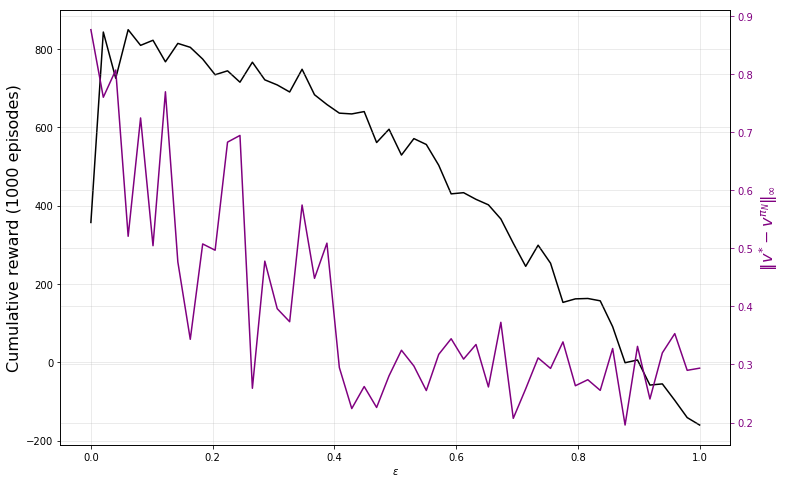

In [8]:
color1 = "k"
color2 = "purple"

fig, ax1 = plt.subplots(figsize=(12,8))

ax1.plot(range_epsilon, all_cum_rewards, color=color1)
ax1.grid(alpha=0.3)
ax1.set_xlabel(r"$\varepsilon$")
ax1.set_ylabel("Cumulative reward (1000 episodes)", color=color1, size=16)
ax1.tick_params('y', colors=color1)

ax2 = ax1.twinx()

ax2.plot(range_epsilon, all_distance_opt_value, color=color2)
ax2.grid(alpha=0.3)
ax2.set_ylabel(r"$|\!|v^{*}-v^{\pi_{N}}|\!|_{\infty}$", color=color2, size=16)
ax2.tick_params('y', colors=color2)

Setting $\varepsilon=0.45$ looks like a good compromise

In [12]:
nr_episodes = 10000
Q, nr_visit, cum_rewards, distance_opt_value = run_Q_learning(env, 
                                                              nr_episodes=nr_episodes, 
                                                              eps=0.45)

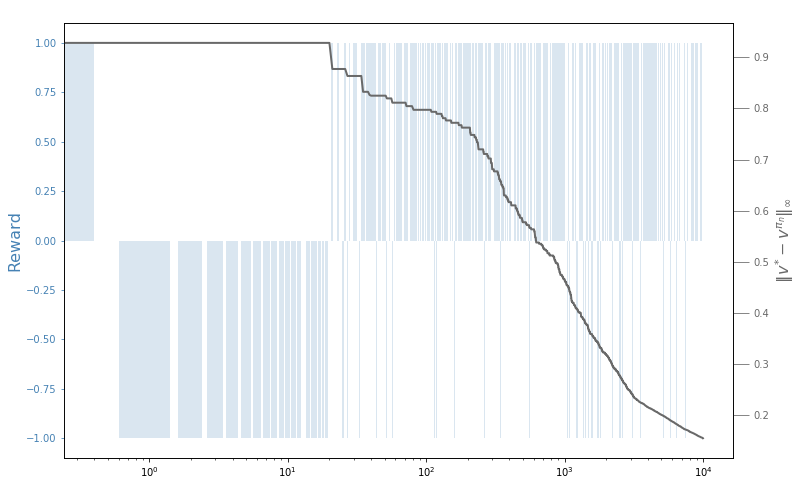

In [13]:
color1 = "steelblue"
color2 = "dimgrey"

fig, ax1 = plt.subplots(figsize=(12,8))

ax1.bar(range(nr_episodes), cum_rewards, color=color1, alpha=0.2)
ax1.set_ylabel("Reward", color=color1, size=16)
ax1.tick_params('y', colors=color1)
ax1.set_xscale('log')

ax2 = ax1.twinx()

ax2.plot(range(nr_episodes), distance_opt_value, color=color2, linewidth="2")
ax2.set_ylabel(r"$|\!|v^{*}-v^{\pi_{n}}|\!|_{\infty}$", color=color2, size=16)
ax2.tick_params('y', colors=color2, size=16)

### Impact of starting state distribution

Intuitively, we would tend to globally, if all pairs state-action are visited an infinite number of times, the optimal policy shouldn't be impacted by the choice of the starting state distribution.
Indeed, policy exploration ensures that asymptotically, all states would have been visited an infinite number of times and Q-value would hence have updated for those states. And as policy-choices keeps memory of the rewards and will tend to yield policies leading positive reward, converging asymptotically toward an optimal policy. There might be several optimal policies, but the "set of optimal policies" would be the same regardless of $\mu_{0}$.